In [ ]:
!pip install spotipy --quiet

In [ ]:
import pandas as pd
import numpy as np
import random
from pandas.io.json import json_normalize
import json
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
import re
import pickle

from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
from collections import defaultdict
from sklearn.utils import resample

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data = json.load(open('/content/gdrive/MyDrive/mpd.slice.0-999.json'))

In [ ]:
df = pd.DataFrame(data["playlists"])

In [ ]:
df

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,tracks,num_edits,duration_ms,num_artists,description
0,Throwbacks,false,0,1493424000,52,47,1,"[{'pos': 0, 'artist_name': 'Missy Elliott', 't...",6,11532414,37,NaN
1,Awesome Playlist,false,1,1506556800,39,23,1,"[{'pos': 0, 'artist_name': 'Survivor', 'track_...",5,11656470,21,NaN
2,korean,false,2,1505692800,64,51,1,"[{'pos': 0, 'artist_name': 'Hoody', 'track_uri...",18,14039958,31,NaN
3,mat,false,3,1501027200,126,107,1,"[{'pos': 0, 'artist_name': 'Camille Saint-Saën...",4,28926058,86,NaN
4,90s,false,4,1401667200,17,16,2,"[{'pos': 0, 'artist_name': 'The Smashing Pumpk...",7,4335282,16,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
995,old,false,995,1507852800,41,40,1,"[{'pos': 0, 'artist_name': 'Katrina', 'track_u...",8,9917901,36,NaN
996,Daze,false,996,1479254400,17,17,1,"[{'pos': 0, 'artist_name': 'PARTYNEXTDOOR', 't...",13,3699248,15,NaN
997,rap,false,997,1410307200,119,98,1,"[{'pos': 0, 'artist_name': 'LoveRance', 'track...",63,27538723,82,NaN
998,Country,false,998,1507939200,108,75,1,"[{'pos': 0, 'artist_name': 'Hunter Hayes', 'tr...",37,24950143,40,NaN


In [ ]:
df.columns

Index(['name', 'collaborative', 'pid', 'modified_at', 'num_tracks',
       'num_albums', 'num_followers', 'tracks', 'num_edits', 'duration_ms',
       'num_artists', 'description'],
      dtype='object')

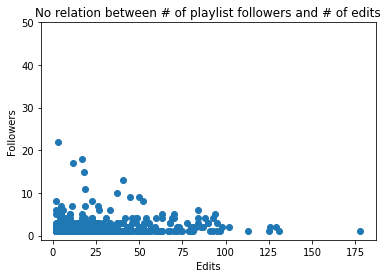

In [ ]:
# Exploratory Data Analysis

plt.plot( df['num_edits'], df['num_followers'], 'o')

# Set limits to avoid the outlier
plt.ylim(-1,50)
plt.title("No relation between # of playlist followers and # of edits")
plt.xlabel("Edits")
plt.ylabel("Followers")
plt.show()

In [ ]:
rplay = random.sample(list(df['name']), 250)

In [ ]:
songs = pd.DataFrame()
j = 0
for i in range(1000):
    if df['name'][i] in rplay:
      temp = pd.DataFrame(df["tracks"][i])
      temp["playlist_name"] = df.name[j]
      temp['pid'] = df.pid[j]
      j += 1
      songs = pd.concat([songs, temp], axis=0)

In [ ]:
songs.columns

Index(['pos', 'artist_name', 'track_uri', 'artist_uri', 'track_name',
       'album_uri', 'duration_ms', 'album_name', 'playlist_name', 'pid'],
      dtype='object')

In [ ]:
songs

,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist_name,pid
0,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,Throwbacks,0
1,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone,Throwbacks,0
2,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit),Throwbacks,0
3,3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified,Throwbacks,0
4,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot,Throwbacks,0
...,...,...,...,...,...,...,...,...,...,...
103,103,Dierks Bentley,spotify:track:5HJId22hZ2IvFnvNSy6ZbE,spotify:artist:7x8nK0m0cP2ksQf0mjWdPS,Different For Girls,spotify:album:2GIrLP0PWskhZAJaHQtDux,180360,Black,90s alternative,334
104,104,Carrie Underwood,spotify:track:0d0tJF80562KcMndcBcSfM,spotify:artist:4xFUf1FHVy696Q1JQZMTRj,Temporary Home,spotify:album:3iLrVuA1k7onNmZTuUQH4u,268560,Play On,90s alternative,334
105,105,Kid Rock,spotify:track:69j0KoPJuwpnbGWrfn7Yll,spotify:artist:7dOBabd5O4CvKrg4iriHTM,Picture (feat. Sheryl Crow) - Featuring Sheryl...,spotify:album:64du8CiAmKAzVswhA3RK4r,298960,Cocky,90s alternative,334
106,106,Brett Eldredge,spotify:track:3Qe097eJNp9MfpT2PieEw0,spotify:artist:0qSX3s5pJnAlSsgsCne8Cz,Don't Ya,spotify:album:7weU5IWFfeueNG5V68CTTT,181209,Bring You Back,90s alternative,334


Text(0.5, 0, 'Total songs across playlists')

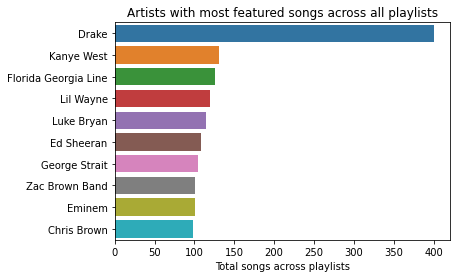

In [ ]:
# Checking which artists are featured most across all playlists
values = list(songs['artist_name'].value_counts())
names = songs['artist_name'].value_counts().index.tolist()

ax = sns.barplot(y=names[0:10], x=values[0:10])
ax.set_title('Artists with most featured songs across all playlists')
ax.set_xlabel('Total songs across playlists')

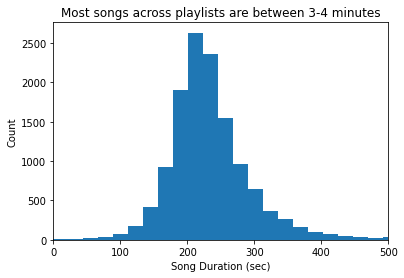

In [ ]:
# Checking the distribution of song durations
songs['duration_sec'] = songs['duration_ms']/1000
plt.title("Most songs across playlists are between 3-4 minutes")
plt.xlabel("Song Duration (sec)")
plt.ylabel("Count")
plt.hist(songs.drop_duplicates(['track_name'], keep='first')['duration_sec'], bins = 100)
plt.xlim(0,500)
plt.show()

In [ ]:
cid = 'ur soptify cid'
secret = 'ur soptify secret key'

In [ ]:
#Authentication - without user
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [ ]:
['id', 'pid', 'artist_name', 'track_uri', 'artist_uri','track_name', 'album_uri', 'album_name', 'playlist_name']

In [ ]:
#songs[['acousticness', 'analysis_url', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'track_href', 'valence']] = ""
songs_data = pd.DataFrame()
for i in range(20366):
  track_uri = songs.iloc[i][2]
  temp_dict = OrderedDict(sp.audio_features(track_uri)[0])
  #songs.at[i, list(temp_dict.keys())] = list(temp_dict.values())
  songs_data.loc[i, list(temp_dict.keys())] = list(temp_dict.values())
  songs_data.loc[i, ['pid', 'artist_name', 'track_uri', 'artist_uri', 'track_name','album_uri', 'album_name', 'playlist_name']] = [songs.iloc[i][9], songs.iloc[i][1],songs.iloc[i][2],songs.iloc[i][3],songs.iloc[i][4],songs.iloc[i][5],songs.iloc[i][7],songs.iloc[i][8]]
  '''print(temp_dict)
  print(list(temp_dict.keys()))
  print(list(temp_dict.values()))
  break'''

In [ ]:
songs_data.to_csv('/content/gdrive/MyDrive/srs_songs_data.csv')

In [ ]:
data_df = pd.read_csv('/content/gdrive/MyDrive/songs_data.csv')
#data_df = data_df.drop(columns=['Unnamed: 0'])

In [ ]:
data_df

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,duration_ms,time_signature,pid,artist_name,track_uri,artist_uri,track_name,album_uri,album_name,playlist_name
0,0,0.904,0.813,4.0,-7.105,0.0,0.1210,0.03110,0.006970,0.0471,...,226864.0,4.0,0.0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,The Cookbook,Throwbacks
1,1,0.774,0.838,5.0,-3.914,0.0,0.1140,0.02490,0.025000,0.2420,...,198800.0,4.0,0.0,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,In The Zone,Throwbacks
2,2,0.664,0.758,2.0,-6.583,0.0,0.2100,0.00238,0.000000,0.0598,...,235933.0,4.0,0.0,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,Dangerously In Love (Alben für die Ewigkeit),Throwbacks
3,3,0.892,0.714,4.0,-6.055,0.0,0.1410,0.20100,0.000234,0.0521,...,267267.0,4.0,0.0,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,Justified,Throwbacks
4,4,0.853,0.606,0.0,-4.596,1.0,0.0713,0.05610,0.000000,0.3130,...,227600.0,4.0,0.0,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,Hot Shot,Throwbacks
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20361,20361,0.719,0.556,9.0,-8.770,1.0,0.0248,0.47700,0.005110,0.0935,...,234813.0,4.0,306.0,Eric Clapton,spotify:track:5EVIK1ZxQF78Ryq4hiWj0F,spotify:artist:6PAt558ZEZl0DmdXlnjMgD,Change The World,spotify:album:2KFj0p0aukp3d62XWLldU3,Forever Man,mixtape
20362,20362,0.791,0.677,5.0,-9.724,1.0,0.0356,0.77600,0.001210,0.2240,...,349280.0,4.0,306.0,Paul Simon,spotify:track:71GvlH0VdeClloLIkHrAVu,spotify:artist:2CvCyf1gEVhI0mX6aFXmVI,Diamonds On the Soles of Her Shoes,spotify:album:6WgGWYw6XXQyLTsWt7tXky,Graceland (25th Anniversary Deluxe Edition),mixtape
20363,20363,0.665,0.673,0.0,-7.950,1.0,0.0493,0.25900,0.000008,0.4970,...,322549.0,4.0,306.0,Elton John,spotify:track:5Wj1rJnCLpMHdLaxsFtJLs,spotify:artist:3PhoLpVuITZKcymswpck5b,Bennie And The Jets - Remastered 2014,spotify:album:5WupqgR68HfuHt3BMJtgun,Goodbye Yellow Brick Road,mixtape
20364,20364,0.795,0.741,0.0,-6.780,1.0,0.0534,0.25400,0.000251,0.1890,...,193373.0,4.0,306.0,Paul Simon,spotify:track:1jBbbJQfOKyBsJNVng8eIy,spotify:artist:2CvCyf1gEVhI0mX6aFXmVI,I Know What I Know,spotify:album:6WgGWYw6XXQyLTsWt7tXky,Graceland (25th Anniversary Deluxe Edition),mixtape


In [ ]:
data_df.columns

Index(['Unnamed: 0', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature', 'pid', 'artist_name', 'track_uri',
       'artist_uri', 'track_name', 'album_uri', 'album_name', 'playlist_name'],
      dtype='object')

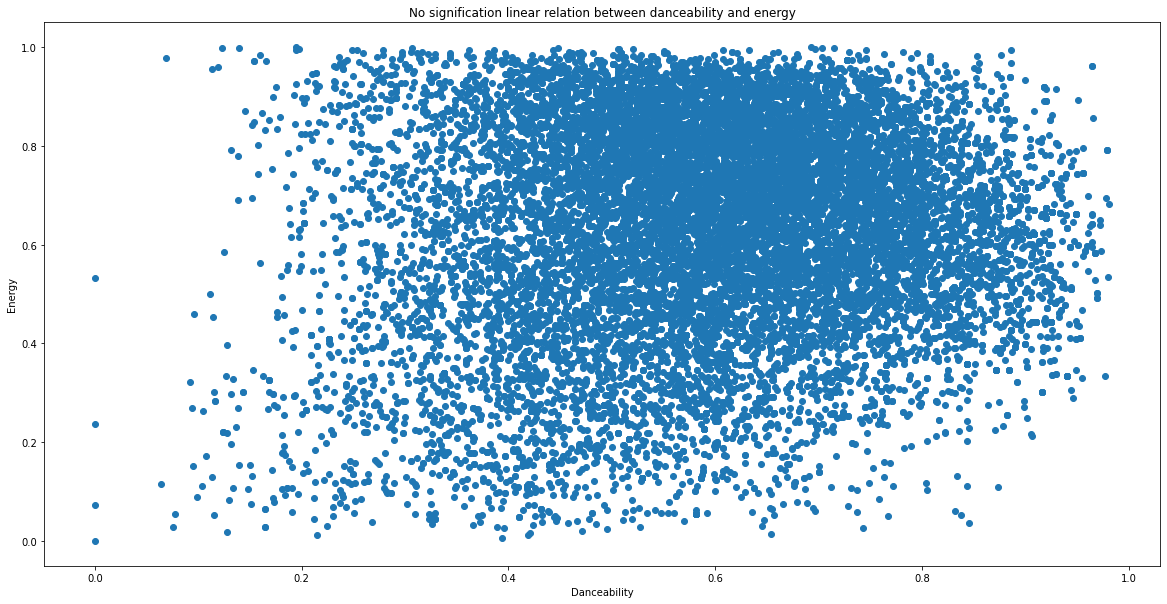

In [ ]:
# Let's do some EDA on our tracks
plt.figure(figsize=(20,10))
plt.plot(data_df['danceability'], data_df['energy'], 'o')
plt.title("No signification linear relation between danceability and energy")
plt.ylabel("Energy")
plt.xlabel("Danceability")
plt.show()

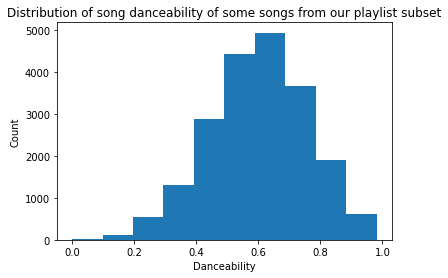

In [ ]:
plt.hist(data_df['danceability'])
plt.title("Distribution of song danceability of some songs from our playlist subset")
plt.ylabel("Count")
plt.xlabel("Danceability")
plt.show()

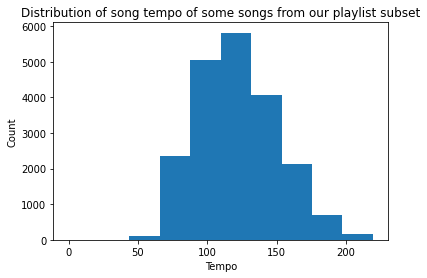

In [ ]:
plt.hist(data_df['tempo'])
plt.title("Distribution of song tempo of some songs from our playlist subset")
plt.ylabel("Count")
plt.xlabel("Tempo")
plt.show()

In [ ]:
data_df

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,duration_ms,time_signature,pid,artist_name,track_uri,artist_uri,track_name,album_uri,album_name,playlist_name
0,0,0.904,0.813,4.0,-7.105,0.0,0.1210,0.03110,0.006970,0.0471,...,226864.0,4.0,0.0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,The Cookbook,Throwbacks
1,1,0.774,0.838,5.0,-3.914,0.0,0.1140,0.02490,0.025000,0.2420,...,198800.0,4.0,0.0,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,In The Zone,Throwbacks
2,2,0.664,0.758,2.0,-6.583,0.0,0.2100,0.00238,0.000000,0.0598,...,235933.0,4.0,0.0,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,Dangerously In Love (Alben für die Ewigkeit),Throwbacks
3,3,0.892,0.714,4.0,-6.055,0.0,0.1410,0.20100,0.000234,0.0521,...,267267.0,4.0,0.0,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,Justified,Throwbacks
4,4,0.853,0.606,0.0,-4.596,1.0,0.0713,0.05610,0.000000,0.3130,...,227600.0,4.0,0.0,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,Hot Shot,Throwbacks
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20361,20361,0.719,0.556,9.0,-8.770,1.0,0.0248,0.47700,0.005110,0.0935,...,234813.0,4.0,306.0,Eric Clapton,spotify:track:5EVIK1ZxQF78Ryq4hiWj0F,spotify:artist:6PAt558ZEZl0DmdXlnjMgD,Change The World,spotify:album:2KFj0p0aukp3d62XWLldU3,Forever Man,mixtape
20362,20362,0.791,0.677,5.0,-9.724,1.0,0.0356,0.77600,0.001210,0.2240,...,349280.0,4.0,306.0,Paul Simon,spotify:track:71GvlH0VdeClloLIkHrAVu,spotify:artist:2CvCyf1gEVhI0mX6aFXmVI,Diamonds On the Soles of Her Shoes,spotify:album:6WgGWYw6XXQyLTsWt7tXky,Graceland (25th Anniversary Deluxe Edition),mixtape
20363,20363,0.665,0.673,0.0,-7.950,1.0,0.0493,0.25900,0.000008,0.4970,...,322549.0,4.0,306.0,Elton John,spotify:track:5Wj1rJnCLpMHdLaxsFtJLs,spotify:artist:3PhoLpVuITZKcymswpck5b,Bennie And The Jets - Remastered 2014,spotify:album:5WupqgR68HfuHt3BMJtgun,Goodbye Yellow Brick Road,mixtape
20364,20364,0.795,0.741,0.0,-6.780,1.0,0.0534,0.25400,0.000251,0.1890,...,193373.0,4.0,306.0,Paul Simon,spotify:track:1jBbbJQfOKyBsJNVng8eIy,spotify:artist:2CvCyf1gEVhI0mX6aFXmVI,I Know What I Know,spotify:album:6WgGWYw6XXQyLTsWt7tXky,Graceland (25th Anniversary Deluxe Edition),mixtape


In [ ]:
data_df.columns

Index(['Unnamed: 0', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature', 'pid', 'artist_name', 'track_uri',
       'artist_uri', 'track_name', 'album_uri', 'album_name', 'playlist_name'],
      dtype='object')

In [ ]:
# Cleaning the data frame and removing features we don't need
df_spotify = data_df.drop_duplicates(['track_uri']).reset_index()
df_spotify_tracks = data_df['track_uri']
df_spotify_track_names = data_df['track_name']

# We will be using the clean df to implement our model
df_spotify_clean = df_spotify.drop(columns=['index', 'Unnamed: 0', 'type', 'id', 'uri', 'track_href', 'analysis_url','artist_name', 'track_uri','artist_uri', 'track_name', 'album_uri', 'album_name', 'playlist_name'])
df_spotify_clean.head(10)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,pid
0,0.904,0.813,4.0,-7.105,0.0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,226864.0,4.0,0.0
1,0.774,0.838,5.0,-3.914,0.0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,198800.0,4.0,0.0
2,0.664,0.758,2.0,-6.583,0.0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,235933.0,4.0,0.0
3,0.892,0.714,4.0,-6.055,0.0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,267267.0,4.0,0.0
4,0.853,0.606,0.0,-4.596,1.0,0.0713,0.05610,0.000000,0.3130,0.654,94.759,227600.0,4.0,0.0
5,0.881,0.788,2.0,-4.669,1.0,0.1680,0.02120,0.000000,0.0377,0.592,104.997,250373.0,4.0,0.0
6,0.662,0.507,5.0,-8.238,1.0,0.1180,0.25700,0.000000,0.0465,0.676,86.412,223440.0,4.0,0.0
7,0.570,0.821,2.0,-4.380,1.0,0.2670,0.17800,0.000000,0.2890,0.408,210.857,225560.0,4.0,0.0
8,0.713,0.678,5.0,-3.525,0.0,0.1020,0.27300,0.000000,0.1490,0.734,138.009,271333.0,4.0,0.0
9,0.727,0.974,4.0,-2.261,0.0,0.0664,0.10300,0.000532,0.1740,0.965,79.526,235213.0,4.0,0.0


In [ ]:
df_spotify.columns

Index(['index', 'Unnamed: 0', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature', 'pid', 'artist_name', 'track_uri',
       'artist_uri', 'track_name', 'album_uri', 'album_name', 'playlist_name'],
      dtype='object')

In [ ]:
def getSubjectivity(text):
  '''
  Getting the Subjectivity using TextBlob
  '''
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  '''
  Getting the Polarity using TextBlob
  '''
  return TextBlob(text).sentiment.polarity

def getAnalysis(score, task="polarity"):
  '''
  Categorizing the Polarity & Subjectivity score
  '''
  if task == "subjectivity":
    if score < 1/3:
      return "low"
    elif score > 1/3:
      return "high"
    else:
      return "medium"
  else:
    if score < 0:
      return 'Negative'
    elif score == 0:
      return 'Neutral'
    else:
      return 'Positive'

def sentiment_analysis(df, text_col):
  '''
  Perform sentiment analysis on text
  ---
  Input:
  df (pandas dataframe): Dataframe of interest
  text_col (str): column of interest
  '''
  df['subjectivity'] = df[text_col].apply(getSubjectivity).apply(lambda x: getAnalysis(x,"subjectivity"))
  df['polarity'] = df[text_col].apply(getPolarity).apply(getAnalysis)
  return df

In [ ]:
sentiment = sentiment_analysis(df_spotify, "track_name")
sentiment.head()

,index,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,pid,artist_name,track_uri,artist_uri,track_name,album_uri,album_name,playlist_name,subjectivity,polarity
0,0,0,0.904,0.813,4.0,-7.105,0.0,0.1210,0.03110,0.006970,...,0.0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,The Cookbook,Throwbacks,low,Neutral
1,1,1,0.774,0.838,5.0,-3.914,0.0,0.1140,0.02490,0.025000,...,0.0,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,In The Zone,Throwbacks,low,Neutral
2,2,2,0.664,0.758,2.0,-6.583,0.0,0.2100,0.00238,0.000000,...,0.0,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,Dangerously In Love (Alben für die Ewigkeit),Throwbacks,high,Negative
3,3,3,0.892,0.714,4.0,-6.055,0.0,0.1410,0.20100,0.000234,...,0.0,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,Justified,Throwbacks,low,Neutral
4,4,4,0.853,0.606,0.0,-4.596,1.0,0.0713,0.05610,0.000000,...,0.0,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,Hot Shot,Throwbacks,low,Neutral


In [ ]:
enc_cols = ['subjectivity','polarity']
encoder = OneHotEncoder(sparse=False, handle_unknown = 'ignore')

#FITTING THE DATA INTO THE ENCODER
encoder.fit(sentiment[enc_cols])
encoded_cols = list(encoder.get_feature_names(enc_cols))
sentiment[encoded_cols] = encoder.transform(sentiment[enc_cols])
#sentiment[['polarity_Negative','polarity_Neutral', 'polarity_Positive']] = encoder.transform(sentiment[['polarity']])

df_spotify_clean.sample(10)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,pid
7352,0.849,0.558,10.0,-9.230,0.0,0.0437,0.0498,0.006340,0.1190,0.350,109.991,253091.0,4.0,146.0
5056,0.658,0.312,9.0,-11.061,1.0,0.0326,0.2910,0.000000,0.1420,0.614,109.695,171493.0,4.0,102.0
6128,0.418,0.534,7.0,-9.841,1.0,0.0326,0.0713,0.000689,0.1430,0.727,160.026,212253.0,3.0,124.0
6939,0.708,0.575,10.0,-5.912,1.0,0.1190,0.1090,0.000000,0.1340,0.127,139.983,238481.0,4.0,139.0
4265,0.980,0.535,2.0,-16.035,1.0,0.0580,0.0270,0.000002,0.1040,0.675,115.744,271467.0,4.0,80.0
9615,0.656,0.677,2.0,-6.929,1.0,0.0285,0.3910,0.000002,0.1180,0.570,112.014,210747.0,4.0,211.0
8401,0.479,0.845,0.0,-4.297,1.0,0.0403,0.4150,0.000604,0.1140,0.649,110.632,166769.0,5.0,173.0
9474,0.734,0.703,1.0,-1.690,0.0,0.1320,0.0344,0.000000,0.1620,0.152,121.080,264973.0,4.0,205.0
6797,0.596,0.789,9.0,-6.380,0.0,0.2270,0.1070,0.025700,0.0532,0.338,170.237,194660.0,4.0,135.0
8337,0.712,0.511,6.0,-5.723,1.0,0.0447,0.1360,0.000000,0.1330,0.182,87.007,214760.0,4.0,171.0


In [ ]:
sentiment.sample(3)

,index,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,album_name,playlist_name,subjectivity,polarity,subjectivity_high,subjectivity_low,subjectivity_medium,polarity_Negative,polarity_Neutral,polarity_Positive
5838,7164,7164,0.881,0.478,4.0,-10.386,1.0,0.0304,0.47600,0.00574,...,Continuum,Gold Digger,low,Neutral,0.0,1.0,0.0,0.0,1.0,0.0
1796,1930,1930,0.747,0.897,9.0,-3.475,1.0,0.0426,0.63000,0.00448,...,La Critica,Running 2.0,low,Neutral,0.0,1.0,0.0,0.0,1.0,0.0
5720,6967,6967,0.403,0.766,2.0,-6.791,1.0,0.0416,0.00546,0.00676,...,Babel,Willie,high,Negative,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
sentiment = sentiment.drop(columns=['index', 'Unnamed: 0','type', 'uri', ])

In [ ]:
df_spotify_prepd = sentiment.copy()

In [ ]:
df_spotify_prepd = df_spotify_prepd.drop(columns=['polarity', 'subjectivity'])

In [ ]:
df_spotify_prepd.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'id', 'track_href', 'analysis_url', 'duration_ms', 'time_signature',
       'pid', 'artist_name', 'track_uri', 'artist_uri', 'track_name',
       'album_uri', 'album_name', 'playlist_name', 'subjectivity_high',
       'subjectivity_low', 'subjectivity_medium', 'polarity_Negative',
       'polarity_Neutral', 'polarity_Positive'],
      dtype='object')

In [ ]:
df_spotify_prepd.to_csv('/content/gdrive/MyDrive/spotify_prepd_data.csv')

In [ ]:
df_spotify_clean[encoded_cols] = df_spotify_prepd[encoded_cols]

In [ ]:
encoded_cols

['subjectivity_high',
 'subjectivity_low',
 'subjectivity_medium',
 'polarity_Negative',
 'polarity_Neutral',
 'polarity_Positive']

In [ ]:
df_spotify_clean = df_spotify_clean.drop(columns=['pid'])

In [ ]:
df_spotify_clean

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,pid,subjectivity_high,subjectivity_low,subjectivity_medium,polarity_Negative,polarity_Neutral,polarity_Positive
0,0.904,0.813,4.0,-7.105,0.0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,226864.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.774,0.838,5.0,-3.914,0.0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,198800.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.664,0.758,2.0,-6.583,0.0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,235933.0,4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.892,0.714,4.0,-6.055,0.0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,267267.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.853,0.606,0.0,-4.596,1.0,0.0713,0.05610,0.000000,0.3130,0.654,94.759,227600.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13220,0.675,0.448,2.0,-11.520,0.0,0.0235,0.32000,0.000000,0.0825,0.568,98.499,271707.0,4.0,306.0,0.0,1.0,0.0,0.0,1.0,0.0
13221,0.483,0.159,7.0,-13.648,1.0,0.0353,0.91400,0.000000,0.1110,0.423,146.721,157893.0,4.0,306.0,0.0,1.0,0.0,0.0,1.0,0.0
13222,0.719,0.556,9.0,-8.770,1.0,0.0248,0.47700,0.005110,0.0935,0.511,96.900,234813.0,4.0,306.0,0.0,1.0,0.0,0.0,1.0,0.0
13223,0.791,0.677,5.0,-9.724,1.0,0.0356,0.77600,0.001210,0.2240,0.876,110.640,349280.0,4.0,306.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
# Standardizing the data
scaler = MinMaxScaler()
scaler.fit(df_spotify_clean)
df_spotify_clean_scaled = scaler.transform(df_spotify_clean)
df_spotify_clean_save = pd.DataFrame()
df_spotify_clean_save[list(df_spotify_clean.columns)] = scaler.transform(df_spotify_clean[list(df_spotify_clean.columns)])

# We create the cosine similarity matrix of the small scaled dataframe we have 
df_spotify_cosine = cosine_similarity(df_spotify_clean_scaled)

In [ ]:
df_spotify_clean_save

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,pid,subjectivity_high,subjectivity_low,subjectivity_medium,polarity_Negative,polarity_Neutral,polarity_Positive
0,0.921509,0.813,0.363636,0.728386,0.0,0.126305,0.031256,0.007005,0.047480,0.818182,0.572105,0.100320,0.8,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.788991,0.838,0.454545,0.816191,0.0,0.118998,0.025025,0.025126,0.243952,0.933333,0.652266,0.087740,0.8,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.676860,0.758,0.181818,0.742749,0.0,0.219207,0.002392,0.000000,0.060282,0.708081,0.452624,0.104385,0.8,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.909276,0.714,0.363636,0.757278,0.0,0.147182,0.202010,0.000235,0.052520,0.825253,0.460435,0.118430,0.8,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.869521,0.606,0.000000,0.797424,1.0,0.074426,0.056382,0.000000,0.315524,0.660606,0.432103,0.100650,0.8,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13220,0.688073,0.448,0.181818,0.606901,0.0,0.024530,0.321608,0.000000,0.083165,0.573737,0.449158,0.120420,0.8,1.0,0.0,1.0,0.0,0.0,1.0,0.0
13221,0.492355,0.159,0.636364,0.548346,1.0,0.036848,0.918593,0.000000,0.111895,0.427273,0.669052,0.069404,0.8,1.0,0.0,1.0,0.0,0.0,1.0,0.0
13222,0.732926,0.556,0.818182,0.682571,1.0,0.025887,0.479397,0.005136,0.094254,0.516162,0.441867,0.103883,0.8,1.0,0.0,1.0,0.0,0.0,1.0,0.0
13223,0.806320,0.677,0.454545,0.656321,1.0,0.037161,0.779899,0.001216,0.225806,0.884848,0.504521,0.155192,0.8,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
df_spotify_clean_save.to_csv('/content/gdrive/MyDrive/spotify_clean_data.csv')

In [ ]:
# We save the cosine similarity arrays as dataframes such that each column gives the similarity one song has with every other song
df_spotify_cosine = pd.DataFrame(df_spotify_cosine)
df_spotify_cosine.head(10)

,0,1,2,3,4,5,6,7,8,9,...,13215,13216,13217,13218,13219,13220,13221,13222,13223,13224
0,1.000000,0.992771,0.621423,0.995491,0.891582,0.910820,0.890932,0.875377,0.986782,0.986197,...,0.766003,0.451153,0.425681,0.830634,0.815378,0.875275,0.719064,0.805419,0.820388,0.842441
1,0.992771,1.000000,0.626886,0.987597,0.886804,0.898444,0.887078,0.880758,0.989567,0.989428,...,0.752247,0.475257,0.435093,0.832664,0.818919,0.866356,0.721349,0.804271,0.821644,0.840258
2,0.621423,0.626886,1.000000,0.612674,0.538104,0.558950,0.517419,0.537376,0.603471,0.625355,...,0.410798,0.605172,0.565243,0.449018,0.472139,0.493134,0.375881,0.461536,0.495594,0.523197
3,0.995491,0.987597,0.612674,1.000000,0.893005,0.907921,0.900298,0.868301,0.991150,0.986493,...,0.773374,0.440530,0.442036,0.851191,0.821654,0.885201,0.743602,0.817627,0.838068,0.845798
4,0.891582,0.886804,0.538104,0.893005,1.000000,0.987233,0.968428,0.956698,0.885477,0.884992,...,0.884561,0.360804,0.514717,0.738396,0.848829,0.805292,0.797776,0.858276,0.880210,0.920419
5,0.910820,0.898444,0.558950,0.907921,0.987233,1.000000,0.977603,0.964103,0.898033,0.897140,...,0.884027,0.397177,0.521532,0.748242,0.866453,0.805924,0.798944,0.875002,0.880017,0.913394
6,0.890932,0.887078,0.517419,0.900298,0.968428,0.977603,1.000000,0.947558,0.901479,0.884004,...,0.884887,0.395386,0.564494,0.801678,0.909078,0.810359,0.864915,0.912755,0.911078,0.905207
7,0.875377,0.880758,0.537376,0.868301,0.956698,0.964103,0.947558,1.000000,0.889085,0.857906,...,0.862450,0.415208,0.523195,0.730184,0.843255,0.787134,0.822682,0.858798,0.866851,0.887456
8,0.986782,0.989567,0.603471,0.991150,0.885477,0.898033,0.901479,0.889085,1.000000,0.979465,...,0.773701,0.464034,0.455967,0.864484,0.830000,0.886008,0.772426,0.829151,0.843634,0.838854
9,0.986197,0.989428,0.625355,0.986493,0.884992,0.897140,0.884004,0.857906,0.979465,1.000000,...,0.753599,0.465926,0.421844,0.824532,0.802555,0.862771,0.702905,0.796923,0.823009,0.842618


In [ ]:
def generate_radio(uri, cosine_df, info_df, num_tracks = 10):
    '''
    Input:
    uri = Track to provide recommendations on
    cosine_df = Cosine similarity df
    info_df = The df with all the songs and track info and audio features
    num_tracks = Number of tracks to recommend
    
    Output:
    rec_songs = df of track names and uri of recommended songs, length = num_tracks 
    '''
    index = info_df.index[info_df['track_uri'] == uri][0]
    similarities = cosine_df.iloc[:, index].sort_values(ascending=False)
    final_indices = list(similarities[1:num_tracks].index)
    rec_songs = info_df[['track_name','artist_name','track_uri']].iloc[final_indices]
    return rec_songs

In [ ]:
# Testing our radio generating function

i = 34
test_uri = df_spotify_tracks[i]
#test_pid = df_spotify['pid'].iloc[i]
print("Song provided:")
display(df_spotify.iloc[34][['track_name','artist_name','track_uri']])
x = generate_radio(test_uri, df_spotify_cosine, df_spotify, 10)
print()
print("Radio recommended")
display(x)

Song provided:


track_name                     Your Love Is My Drug
artist_name                                   Kesha
track_uri      spotify:track:3uoQULcUWfnt6nc6J7Vgai
Name: 34, dtype: object


Radio recommended


,track_name,artist_name,track_uri
759,Sexual,NEIKED,spotify:track:3AsAuGTaDQzavZZThyYlop
556,Intoxicated - New Radio Mix,Martin Solveig,spotify:track:5bcfWAHLoMfGBdbeyoMaH3
70,We Found Love,Rihanna,spotify:track:6qn9YLKt13AGvpq9jfO8py
3229,Loyal,Chris Brown,spotify:track:7kqcudBGM74MXVoYMaoWkC
657,The Sweet Escape,Gwen Stefani,spotify:track:26eOTllWPn7oKuDUJnsJwF
1521,I'm Ready,Tevin Campbell,spotify:track:1eGY6roK1W2vFIhDXu2lXq
113,Love More,Chris Brown,spotify:track:2bEvCSQQha48I5ZQUCvLzP
3332,Celebrate Good Times (Come On),Funktown America,spotify:track:7GebhNsNL8mm3D218sd1IM
1116,Don't Get Too High,Bryson Tiller,spotify:track:0OVhQZkNe7lh0fQeH96EFW


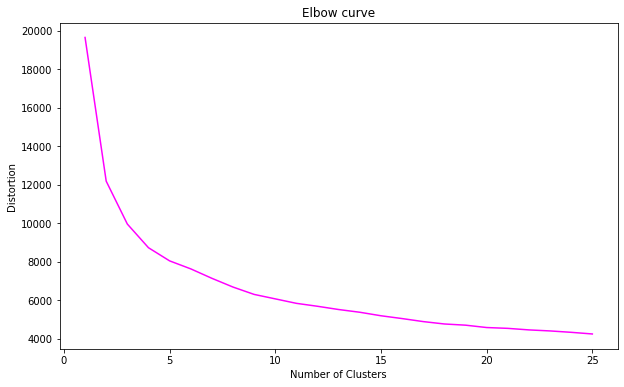

In [ ]:
distortion = []
for k in range(1, 26):  
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(df_spotify_clean_scaled)
    distortion.append(kmeans.inertia_)

# Plotting elbow curves 
# It seems around 8 clusters seem to be optimum
# We can use 10 clusters just to make sure we have enough clusters to capture the variance in data

fig = plt.figure(figsize=(10, 6))
plt.plot(range(1, 26), distortion, c = 'magenta')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow curve')
plt.show()

In [ ]:
def generate_playlist_cluster(playlist, df_scaled_features, info_df, num_clusters = 7, random_state = 10):
    
    '''
    Input:
    playlist = Playlist based on which to provide recommendations 
    df_scaled_features = df will all the scaled audio features of our songs
    info_df = The df with all the songs and track info and audio features
    num_clusters = Number of clusters to use for k-means clustering
    random_state = Random state for k-clustering 
    
    Output:
    recs = A df that will be the recommended playlist
    '''
    #pid = list(info_df[info_df['track_uri'].isin(playlist)]['pid'].value_counts().index)[0]
    df_k = pd.DataFrame(df_scaled_features.copy())
    playlist_name = list(dict(playlist.playlist_name.value_counts()).keys())[0]

    # fit clusters
    kmeans = KMeans(n_clusters = num_clusters, random_state = random_state)
    kmeans.fit(df_k)
    
    # get label
    label = kmeans.labels_
    # Assigning labels to each song
    df_k['cluster_label'] = label
    
    # For a given playlist, checking which cluster label the playlist had the highest
    #mode_cluster = list(df_k[info_df['pid'] == pid]['cluster_label'].value_counts().index)[0]
    cluster_dict = dict((df_k.iloc[df_spotify[df_spotify['playlist_name'] == playlist_name].index].cluster_label.value_counts()))
    print(cluster_dict)
    mode_cluster = max(cluster_dict, key=cluster_dict.get)
    
    # Finding songs not on our playlist by with same cluster label
    our_df = df_spotify[~(df_spotify['track_uri'].isin(playlist)) & (df_k['cluster_label'] == mode_cluster)]

    # Then among those songs, taking a single song from each artist 
    # The loop starts with the artist with the highest songs and then goes down and repeats
    # We do this until our recommendation is complete
    
    artist_names = list(df_spotify[df_k['cluster_label'] == mode_cluster]['artist_name'].value_counts().index)
    recs = []
    counter = 0
    while (len(recs) < 2*len(playlist)) & (counter < len(our_df[our_df['artist_name'] == artist_names[0]]['track_uri'])):    
        for artist in artist_names:
                songs = our_df[our_df['artist_name'] == artist]['track_uri']
                if len(songs) > counter + 1:
                    recs.append(list(songs)[counter])
        counter += 1   
    recs = info_df[info_df['track_uri'].isin(recs)]
    print(df_k.cluster_label.value_counts())    
    pickle.dump(kmeans, open("kmeans_model.pkl", 'wb')) #Saving the model
    return recs.iloc[0:len(playlist)]

In [ ]:
kmeans = pickle.load(open('kmeans_model.pkl', 'rb'))

In [ ]:
df = df_spotify.append(user_playlist, ignore_index=True)

In [ ]:
kmeans.predict(user_playlist_clean)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int32)

In [ ]:
c = list(kmeans.predict(user_playlist_clean))
c

In [ ]:
generate_playlist_cluster(user_playlist, user_playlist_clean, df, num_clusters = 7, random_state = 10)

NameError: ignored

In [ ]:
df_spotify_clean_save

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,subjectivity_high,subjectivity_low,subjectivity_medium,polarity_Negative,polarity_Neutral,polarity_Positive
0,0.921509,0.813,0.363636,0.728386,0.0,0.126305,0.031256,0.007005,0.047480,0.818182,0.572105,0.100320,0.8,0.0,1.0,0.0,0.0,1.0,0.0
1,0.788991,0.838,0.454545,0.816191,0.0,0.118998,0.025025,0.025126,0.243952,0.933333,0.652266,0.087740,0.8,0.0,1.0,0.0,0.0,1.0,0.0
2,0.676860,0.758,0.181818,0.742749,0.0,0.219207,0.002392,0.000000,0.060282,0.708081,0.452624,0.104385,0.8,1.0,0.0,0.0,1.0,0.0,0.0
3,0.909276,0.714,0.363636,0.757278,0.0,0.147182,0.202010,0.000235,0.052520,0.825253,0.460435,0.118430,0.8,0.0,1.0,0.0,0.0,1.0,0.0
4,0.869521,0.606,0.000000,0.797424,1.0,0.074426,0.056382,0.000000,0.315524,0.660606,0.432103,0.100650,0.8,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13220,0.688073,0.448,0.181818,0.606901,0.0,0.024530,0.321608,0.000000,0.083165,0.573737,0.449158,0.120420,0.8,0.0,1.0,0.0,0.0,1.0,0.0
13221,0.492355,0.159,0.636364,0.548346,1.0,0.036848,0.918593,0.000000,0.111895,0.427273,0.669052,0.069404,0.8,0.0,1.0,0.0,0.0,1.0,0.0
13222,0.732926,0.556,0.818182,0.682571,1.0,0.025887,0.479397,0.005136,0.094254,0.516162,0.441867,0.103883,0.8,0.0,1.0,0.0,0.0,1.0,0.0
13223,0.806320,0.677,0.454545,0.656321,1.0,0.037161,0.779899,0.001216,0.225806,0.884848,0.504521,0.155192,0.8,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
pd.DataFrame(df_spotify_clean_scaled)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.921509,0.813,0.363636,0.728386,0.0,0.126305,0.031256,0.007005,0.047480,0.818182,0.572105,0.100320,0.8,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.788991,0.838,0.454545,0.816191,0.0,0.118998,0.025025,0.025126,0.243952,0.933333,0.652266,0.087740,0.8,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.676860,0.758,0.181818,0.742749,0.0,0.219207,0.002392,0.000000,0.060282,0.708081,0.452624,0.104385,0.8,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.909276,0.714,0.363636,0.757278,0.0,0.147182,0.202010,0.000235,0.052520,0.825253,0.460435,0.118430,0.8,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.869521,0.606,0.000000,0.797424,1.0,0.074426,0.056382,0.000000,0.315524,0.660606,0.432103,0.100650,0.8,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13220,0.688073,0.448,0.181818,0.606901,0.0,0.024530,0.321608,0.000000,0.083165,0.573737,0.449158,0.120420,0.8,1.0,0.0,1.0,0.0,0.0,1.0,0.0
13221,0.492355,0.159,0.636364,0.548346,1.0,0.036848,0.918593,0.000000,0.111895,0.427273,0.669052,0.069404,0.8,1.0,0.0,1.0,0.0,0.0,1.0,0.0
13222,0.732926,0.556,0.818182,0.682571,1.0,0.025887,0.479397,0.005136,0.094254,0.516162,0.441867,0.103883,0.8,1.0,0.0,1.0,0.0,0.0,1.0,0.0
13223,0.806320,0.677,0.454545,0.656321,1.0,0.037161,0.779899,0.001216,0.225806,0.884848,0.504521,0.155192,0.8,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
generate_playlist_cluster(df_spotify[df_spotify['playlist_name'] == "Throwbacks"], df_spotify_clean_save, df_spotify, num_clusters = 7, random_state = 10)

{1: 27, 0: 12, 2: 5, 3: 4, 5: 2, 6: 1}
1    4914
0    3010
4    1793
2    1530
3     824
5     578
6     576
Name: cluster_label, dtype: int64


,index,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,album_name,playlist_name,subjectivity,polarity,subjectivity_high,subjectivity_low,subjectivity_medium,polarity_Negative,polarity_Neutral,polarity_Positive
4,4,4,0.853,0.606,0.0,-4.596,1.0,0.0713,0.056100,0.000000,...,Hot Shot,Throwbacks,low,Neutral,0.0,1.0,0.0,0.0,1.0,0.0
5,5,5,0.881,0.788,2.0,-4.669,1.0,0.1680,0.021200,0.000000,...,Confessions,Throwbacks,low,Neutral,0.0,1.0,0.0,0.0,1.0,0.0
7,7,7,0.570,0.821,2.0,-4.380,1.0,0.2670,0.178000,0.000000,...,PCD,Throwbacks,low,Neutral,0.0,1.0,0.0,0.0,1.0,0.0
13,13,13,0.687,0.710,9.0,-5.840,1.0,0.0522,0.028300,0.000004,...,Departure - Recharged,Throwbacks,low,Neutral,0.0,1.0,0.0,0.0,1.0,0.0
16,16,16,0.487,0.900,0.0,-4.417,1.0,0.0482,0.000068,0.000000,...,Let Go,Throwbacks,low,Neutral,0.0,1.0,0.0,0.0,1.0,0.0
18,18,18,0.705,0.796,7.0,-6.845,1.0,0.2670,0.070800,0.000000,...,B'Day,Throwbacks,low,Neutral,0.0,1.0,0.0,0.0,1.0,0.0
19,19,19,0.771,0.685,1.0,-4.639,1.0,0.0567,0.005430,0.001570,...,The Writing's On The Wall,Throwbacks,low,Neutral,0.0,1.0,0.0,0.0,1.0,0.0
22,22,22,0.728,0.801,4.0,-3.636,1.0,0.0752,0.003490,0.000195,...,I've Never Done Anything Like This,Throwbacks,low,Neutral,0.0,1.0,0.0,0.0,1.0,0.0
25,25,25,0.659,0.869,11.0,-5.858,1.0,0.0460,0.003570,0.000000,...,Jonas Brothers,Throwbacks,low,Neutral,0.0,1.0,0.0,0.0,1.0,0.0
27,27,27,0.624,0.976,8.0,-5.355,1.0,0.0494,0.004000,0.000012,...,Everytime We Touch,Throwbacks,low,Neutral,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
pickle.dump(kmeans, open("kmeans_model.pkl", 'wb')) #Saving the model
pickle.dump(encoder, open("encoder.pkl", 'wb')) 
pickle.dump(scaler, open("scaler.pkl", 'wb')) 

In [ ]:
'''kmeans = pickle.load(open('kmeans_model.pkl', 'rb'))
encoder = pickle.load(open('encoder.pkl', 'rb'))
scaler = pickle.load(open('scaler.pkl', 'rb'))'''
spotify_prepd = pd.read_csv('/content/gdrive/MyDrive/spotify_prepd_data.csv')
spotify_prepd_clean = pd.read_csv('/content/gdrive/MyDrive/spotify_clean_data.csv')
spotify_prepd = spotify_prepd.drop(columns=['Unnamed: 0'])
spotify_prepd_clean = spotify_prepd_clean.drop(columns=['Unnamed: 0', "pid"])

In [ ]:
kmeans = pickle.load(open('kmeans_model.pkl', 'rb'))

In [ ]:
cid = 'ur soptify cid'
secret = 'ur soptify secret key'

In [ ]:
#Authentication - without user
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [ ]:
playlist_link = 'https://open.spotify.com/playlist/5crsIQPlyoRK6FXfJEP9EE?si=bcf3c01fc08a4bcf'
playlist_URI = playlist_link.split("/")[-1].split("?")[0]
track_uris = [x["track"]["uri"] for x in sp.playlist_tracks(playlist_URI)["items"]]

In [ ]:
user_playlist = pd.DataFrame()
i = 0
playlist_name = "chill_spotify"
for track in sp.playlist_tracks(playlist_URI)["items"]:
    user_playlist.loc[i,['id', 'pid', 'artist_name', 'track_uri', 'artist_uri','track_name', 'album_uri', 'album_name', 'playlist_name']] = [track["track"]["id"], 307, track["track"]["artists"][0]["name"], track["track"]["uri"], track["track"]["artists"][0]["uri"], track["track"]["name"], track["track"]["album"]["uri"], track["track"]["album"]["name"], playlist_name]
    track_uri = user_playlist.iloc[i][3]
    temp_dict = OrderedDict(sp.audio_features(track_uri)[0])
    user_playlist.loc[i, list(temp_dict.keys())] = list(temp_dict.values())
    i += 1
user_playlist = user_playlist.drop(columns=['uri', 'type'])
user_playlist = sentiment_analysis(user_playlist, "track_name")
# One-hot encoding for the subjectivity and polarity
enc_cols = ['polarity', 'subjectivity']
encoded_cols = ['subjectivity_high','subjectivity_low','subjectivity_medium','polarity_Negative','polarity_Neutral','polarity_Positive']

user_playlist[encoded_cols] = encoder.transform(user_playlist[enc_cols])
user_playlist_clean = user_playlist.copy()
user_playlist_clean = user_playlist_clean.drop(columns=['polarity','subjectivity'])
user_playlist = user_playlist.drop(columns=['polarity','subjectivity'])

user_playlist_clean = user_playlist_clean.drop_duplicates(['track_uri']).reset_index()
user_playlist_clean = user_playlist_clean.drop(columns=['id','track_href', 'analysis_url','artist_name', 'track_uri','artist_uri', 'track_name', 'album_uri', 'album_name', 'playlist_name'])
#Scaling the columns' data
#user_playlist_clean = scaler.transform(user_playlist_clean)
user_playlist_clean = user_playlist_clean.drop(columns=['index'])
user_playlist_clean[list(user_playlist_clean.columns)] = scaler.transform(user_playlist_clean[list(user_playlist_clean.columns)])
#user_playlist_clean = user_playlist_clean.drop(columns=['index'])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [ ]:
c = list(kmeans.predict(user_playlist_clean))
c

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [ ]:
user_playlist_clean.columns

Index(['pid', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature',
       'subjectivity_high', 'subjectivity_low', 'subjectivity_medium',
       'polarity_Negative', 'polarity_Neutral', 'polarity_Positive'],
      dtype='object')

In [ ]:
len(list(spotify_prepd.columns))

30

In [ ]:
user_playlist_clean

,index,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,subjectivity_high,subjectivity_low,subjectivity_medium,polarity_Negative,polarity_Neutral,polarity_Positive
0,0.000000,0.939,0.050091,0.951406,-9.126,1.043841,0.292462,0.031256,0.000000,0.193939,0.001915,-0.001317,67588.2,0.013072,0.0,0.0,0.0,0.0,0.0,0.0
1,1.019368,0.877,0.047000,0.978922,-5.426,0.000000,0.070955,0.218090,0.000000,0.144444,0.001163,-0.001316,32410.6,0.013072,0.0,0.0,0.0,0.0,0.0,0.0
2,2.038736,0.764,0.065818,0.951406,-4.748,0.000000,0.369849,0.443216,0.000001,0.178788,0.003767,-0.001332,67226.6,0.013072,0.0,0.0,0.0,0.0,0.0,0.0
3,3.058104,0.729,0.067091,1.171537,-5.325,0.000000,0.278392,0.024221,0.000000,0.407071,0.003301,-0.001330,41240.0,0.013072,0.0,0.0,0.0,0.0,0.0,0.0
4,4.077472,0.904,0.068727,1.199053,-3.746,1.043841,0.321608,0.069548,0.000000,0.342424,0.001560,-0.001307,57617.4,0.013072,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.646279,0.954,0.064636,0.951406,-7.324,1.043841,0.279397,0.391960,0.000000,0.537374,0.002472,-0.001316,64300.0,0.013072,0.0,0.0,0.0,0.0,0.0,0.0
86,87.665647,0.837,0.080727,1.144021,-4.819,1.043841,0.061005,0.162814,0.000000,0.227273,0.002426,-0.001312,24369.2,0.013072,0.0,0.0,0.0,0.0,0.0,0.0
87,88.685015,0.636,0.065909,1.199053,-7.279,0.000000,0.423116,0.102513,0.000000,0.366667,0.003242,-0.001319,42917.6,0.016340,0.0,0.0,0.0,0.0,0.0,0.0
88,89.704383,0.879,0.052818,0.951406,-5.694,1.043841,0.191960,0.151759,0.000000,0.094747,0.001518,-0.001325,42450.0,0.013072,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_playlist

,id,pid,artist_name,track_uri,artist_uri,track_name,album_uri,album_name,playlist_name,danceability,...,track_href,analysis_url,duration_ms,time_signature,subjectivity_high,subjectivity_low,subjectivity_medium,polarity_Negative,polarity_Neutral,polarity_Positive
0,2jt2WxXMCD4zjACthkJQVE,307.0,Eminem,spotify:track:2jt2WxXMCD4zjACthkJQVE,spotify:artist:7dGJo4pcD2V6oG8kP0tJRR,The Ringer,spotify:album:3HNnxK7NgLXbDoxRZxNWiR,Kamikaze,WorkDHellouT,0.939,...,https://api.spotify.com/v1/tracks/2jt2WxXMCD4z...,https://api.spotify.com/v1/audio-analysis/2jt2...,337941.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5BbdKBZO0TH0GhfxUfyhL9,307.0,Lil Baby,spotify:track:5BbdKBZO0TH0GhfxUfyhL9,spotify:artist:5f7VJjfbwm532GiveGC0ZK,Freestyle,spotify:album:750APP0eKVlcgOxaZnBnVt,Too Hard,WorkDHellouT,0.877,...,https://api.spotify.com/v1/tracks/5BbdKBZO0TH0...,https://api.spotify.com/v1/audio-analysis/5Bbd...,162053.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5ASZFbCod633wLragmPYTj,307.0,JAY-Z,spotify:track:5ASZFbCod633wLragmPYTj,spotify:artist:3nFkdlSjzX9mRTtwJOzDYB,Renegade,spotify:album:5qENHeCSlwWpEzb25peRmQ,Curtain Call: The Hits (Deluxe Edition),WorkDHellouT,0.764,...,https://api.spotify.com/v1/tracks/5ASZFbCod633...,https://api.spotify.com/v1/audio-analysis/5ASZ...,336133.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35sTnIGxofSPnaIfJKgWmJ,307.0,Ice Cube,spotify:track:35sTnIGxofSPnaIfJKgWmJ,spotify:artist:3Mcii5XWf6E0lrY3Uky4cA,It Takes A Nation,spotify:album:3xbWu3mLkkWZvgHtExIaKZ,Raw Footage,WorkDHellouT,0.729,...,https://api.spotify.com/v1/tracks/35sTnIGxofSP...,https://api.spotify.com/v1/audio-analysis/35sT...,206200.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
4,28FGV3ORH14MYORd7s5dlU,307.0,Eminem,spotify:track:28FGV3ORH14MYORd7s5dlU,spotify:artist:7dGJo4pcD2V6oG8kP0tJRR,Not Alike (feat. Royce Da 5'9),spotify:album:3HNnxK7NgLXbDoxRZxNWiR,Kamikaze,WorkDHellouT,0.904,...,https://api.spotify.com/v1/tracks/28FGV3ORH14M...,https://api.spotify.com/v1/audio-analysis/28FG...,288087.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,6a0FFmCysnpLTt5sDLUABH,307.0,KR$NA,spotify:track:6a0FFmCysnpLTt5sDLUABH,spotify:artist:5C1S9XwxMuuCciutwMhp5t,Makasam,spotify:album:4nitnnHvFPQ03dN8guRp3d,Makasam,WorkDHellouT,0.954,...,https://api.spotify.com/v1/tracks/6a0FFmCysnpL...,https://api.spotify.com/v1/audio-analysis/6a0F...,321500.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
86,4QOzAUSLD0NPlhCsA25lZO,307.0,KR$NA,spotify:track:4QOzAUSLD0NPlhCsA25lZO,spotify:artist:5C1S9XwxMuuCciutwMhp5t,Fall Off (Interlude),spotify:album:3TWJqzaophqIi6ZIm5wkux,Still Here,WorkDHellouT,0.837,...,https://api.spotify.com/v1/tracks/4QOzAUSLD0NP...,https://api.spotify.com/v1/audio-analysis/4QOz...,121846.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
87,3PpzBZMTrCuNx4TC6SZN69,307.0,KR$NA,spotify:track:3PpzBZMTrCuNx4TC6SZN69,spotify:artist:5C1S9XwxMuuCciutwMhp5t,Saath Ya Khilaaf,spotify:album:5Y73P4JbAElupnQAZCStkR,Saath Ya Khilaaf,WorkDHellouT,0.636,...,https://api.spotify.com/v1/tracks/3PpzBZMTrCuN...,https://api.spotify.com/v1/audio-analysis/3Ppz...,214588.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
88,0x5itC1IF7WtrA7lJUmIbf,307.0,Aghor,spotify:track:0x5itC1IF7WtrA7lJUmIbf,spotify:artist:3AsmJFW9t14OXuJp9zOuPk,Batman,spotify:album:75K8WUFvfA5ejXARa0y60o,Batman,WorkDHellouT,0.879,...,https://api.spotify.com/v1/tracks/0x5itC1IF7Wt...,https://api.spotify.com/v1/audio-analysis/0x5i...,212250.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def generate_playlist_cluster(kmeans, playlist, df_scaled_features, info_df, num_clusters = 7, random_state = 10):
    
    #pid = list(info_df[info_df['track_uri'].isin(playlist)]['pid'].value_counts().index)[0]
    df_k = pd.DataFrame(df_scaled_features.copy())
    playlist_name = list(dict(playlist.playlist_name.value_counts()).keys())[0]

    # fit clusters
    clusters = list(kmeans.predict(df_scaled_features))
    
    # get label
    label = kmeans.labels_
    # Assigning labels to each song
    df_k['cluster_label'] = label
    
    # For a given playlist, checking which cluster label the playlist had the highest
    #mode_cluster = list(df_k[info_df['pid'] == pid]['cluster_label'].value_counts().index)[0]
    cluster_dict = dict((df_k.iloc[df_spotify[df_spotify['playlist_name'] == playlist_name].index].cluster_label.value_counts()))
    print(cluster_dict)
    #mode_cluster = max(cluster_dict, key=cluster_dict.get)
    mode_cluster = max(set(List), key = List.count)
    
    # Finding songs not on our playlist by with same cluster label
    our_df = df_spotify[~(df_spotify['track_uri'].isin(playlist)) & (df_k['cluster_label'] == mode_cluster)]

    # Then among those songs, taking a single song from each artist 
    # The loop starts with the artist with the highest songs and then goes down and repeats
    # We do this until our recommendation is complete
    
    artist_names = list(df_spotify[df_k['cluster_label'] == mode_cluster]['artist_name'].value_counts().index)
    recs = []
    counter = 0
    while (len(recs) < 2*len(playlist)) & (counter < len(our_df[our_df['artist_name'] == artist_names[0]]['track_uri'])):    
        for artist in artist_names:
                songs = our_df[our_df['artist_name'] == artist]['track_uri']
                if len(songs) > counter + 1:
                    recs.append(list(songs)[counter])
        counter += 1   
    recs = info_df[info_df['track_uri'].isin(recs)]
    print(df_k.cluster_label.value_counts())    
    return recs.iloc[0:len(playlist)]

In [ ]:
a = pd.read_csv('/content/gdrive/MyDrive/spotify_clean_data.csv')

In [ ]:
a[clusters] = 

SyntaxError: ignored